# Semantic Segmentation using Detectron2 (pointe rend) and Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# uncomment two following if u haven't install detectron2 library
# !git clone https://github.com/facebookresearch/detectron2.git
# !python -m pip install -e detectron2

# comment the following if u haven't install detectron2 library
!python -m pip install -e /content/drive/MyDrive/Colab_Notebooks/detectron2

exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Obtaining file:///content/drive/MyDrive/Colab_Notebooks/detectron2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=aaf91eb40abff8a3eaa42c816b8dad58b4b9edaa4af8c36afca5936f5ad2bc9c
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=efeef7d8bf4900275

In [ ]:
# uncomment if you want to save the library in gdrive

# import shutil

# # Assuming Detectron2 is in /content/detectron2
# source_path = '/content/detectron2'

# # Destination path in your Google Drive
# destination_path = '/content/drive/MyDrive/Colab_Notebooks'

# # Copy the Detectron2 library to Google Drive
# shutil.copytree(source_path, destination_path)

In [1]:
!pip show torch

Name: torch
Version: 2.1.0+cu118
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, triton, typing-extensions
Required-by: fastai, torchaudio, torchdata, torchtext, torchvision


In [2]:
# check pytorch installation:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("2.1")   # please manually install torch 2.1 if Colab changes its default version

2.1.0+cu118 True


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import torch
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog

# import PointRend project
from detectron2.projects import point_rend

If you want to use %run code you have to modify the demo.py inside detectron2 by adding `point_rend.add_pointrend_config(cfg)` below `cfg = get_cfg()`

the video result will have different color segmentation each frame if use this

In [ ]:
# %run /content/drive/MyDrive/Colab_Notebooks/detectron2/demo/demo.py
# --config-file /content/drive/MyDrive/Colab_Notebooks/detectron2/projects/PointRend/configs/SemanticSegmentation/pointrend_semantic_R_101_FPN_1x_cityscapes.yaml
# --video-input samples.mp4
# --confidence-threshold 0.6
# --output video-output.mkv \
# --opts MODEL.WEIGHTS detectron2://PointRend/SemanticSegmentation/pointrend_semantic_R_101_FPN_1x_cityscapes/202576688/model_final_cf6ac1.pkl

So i done manually for each frame so that it has the same color segmentation

In [16]:
import random

# Provided color list
provided_colors = [
    (255, 0, 0),     # Red
    (0, 255, 0),     # Green
    (0, 0, 255),     # Blue
    (255, 255, 0),   # Yellow
    (255, 0, 255),   # Magenta
    (0, 255, 255),   # Cyan
    (128, 0, 0),     # Maroon
    (0, 128, 0),     # Olive
    (0, 0, 128),     # Navy
    (128, 128, 0),   # Olive Green
    (128, 0, 128),   # Purple
    (0, 128, 128),   # Teal
    (255, 165, 0),   # Orange
    (128, 128, 128), # Gray
    (128, 128, 255), # Periwinkle
    (128, 0, 64),    # Rose
    (0, 128, 64),    # Jade
    (64, 0, 128),    # Indigo
    (255, 128, 128), # Light Salmon
    (128, 255, 128), # Pale Green
    (173, 216, 230), # Light Blue
    (255, 99, 71),   # Tomato
    (0, 255, 128),   # Spring Green
    (255, 192, 203), # Pink
    (0, 128, 192),   # Steel Blue
]

# Randomize the order
random.shuffle(provided_colors)

# Create the class-to-color mapping
class_colors = {i: color for i, color in enumerate(provided_colors)}

# Load configuration and model
dataset_name = "cityscapes_fine_sem_seg_val"
config_file = "/content/drive/MyDrive/Colab_Notebooks/detectron2/projects/PointRend/configs/SemanticSegmentation/pointrend_semantic_R_101_FPN_1x_cityscapes.yaml"
weights_file = "detectron2://PointRend/SemanticSegmentation/pointrend_semantic_R_101_FPN_1x_cityscapes/202576688/model_final_cf6ac1.pkl"

metadata = MetadataCatalog.get(dataset_name)

cfg = get_cfg()
point_rend.add_pointrend_config(cfg)
cfg.merge_from_file(config_file)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = weights_file

# Load predictor
predictor = DefaultPredictor(cfg)

# Replace with your desired video path
video_path = "/content/samples.mp4"
cap = cv2.VideoCapture(video_path)

# Get video details
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can choose other codecs like 'XVID' as well
output_video_path = "output_video.mp4"
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Create a blank image to store colored segmentation map
    colored_sem_seg = np.zeros_like(frame)

    # Perform inference on each frame
    outputs = predictor(frame)
    sem_seg = outputs["sem_seg"].argmax(dim=0).to("cpu").numpy()

    # Visualize using the Visualizer
    visualizer = Visualizer(colored_sem_seg, metadata)
    visualizer.draw_sem_seg(sem_seg, area_threshold=None, alpha=0)
    vis_image = visualizer.get_output()

    # Map class indices to colors
    for class_idx, color in class_colors.items():
        mask = (sem_seg == class_idx)
        colored_sem_seg[mask] = color

    # Blend the original frame with the colored segmentation map
    overlaid_frame = cv2.addWeighted(colored_sem_seg, 0.6, vis_image.get_image(), 1, 0)

    overlaid_frame2 = cv2.addWeighted(frame, 0.2, overlaid_frame, 1, 0)

    # Display the result
    # cv2_imshow(overlaid_frame2)
    # Save the frame to the output video
    out.write(overlaid_frame2)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release everything when the job is finished
cap.release()
out.release()
cv2.destroyAllWindows()

[12/11 06:19:37 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://PointRend/SemanticSegmentation/pointrend_semantic_R_101_FPN_1x_cityscapes/202576688/model_final_cf6ac1.pkl ...


  pixel_mean
  pixel_std


In [17]:
from google.colab import files

# Specify the file path
file_path = '/content/output_video.mp4'

# Trigger the download
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

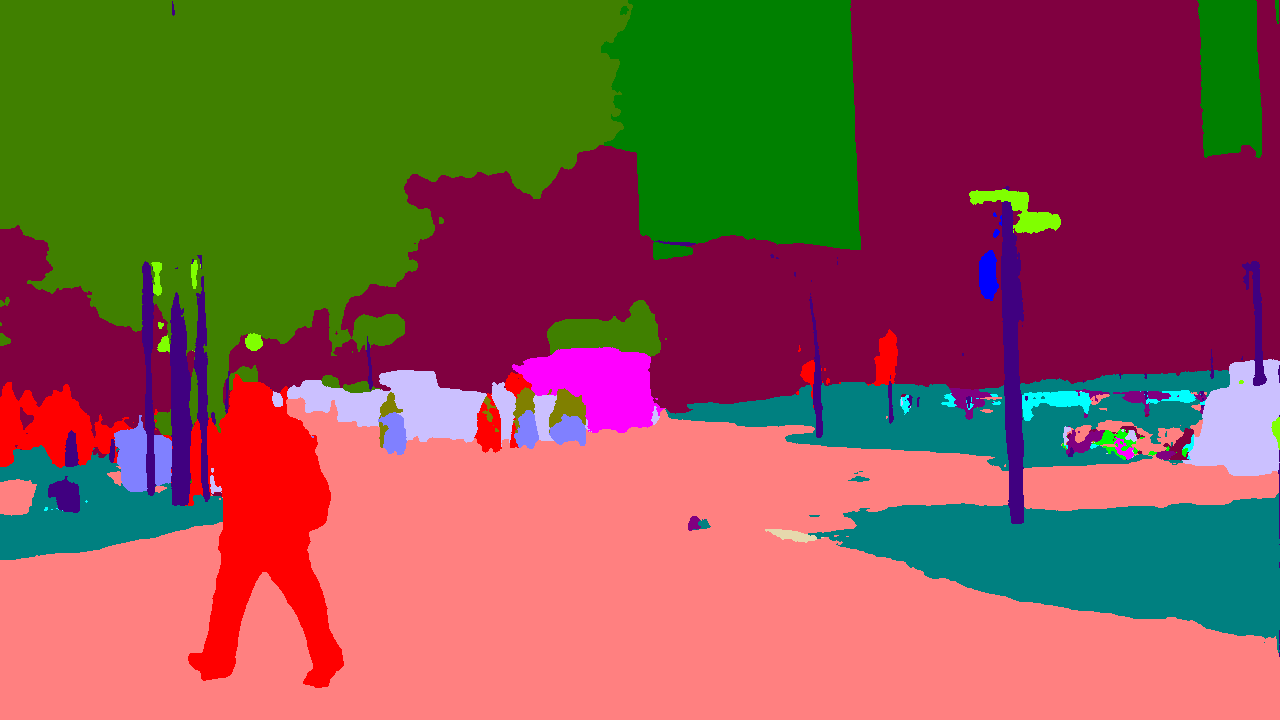

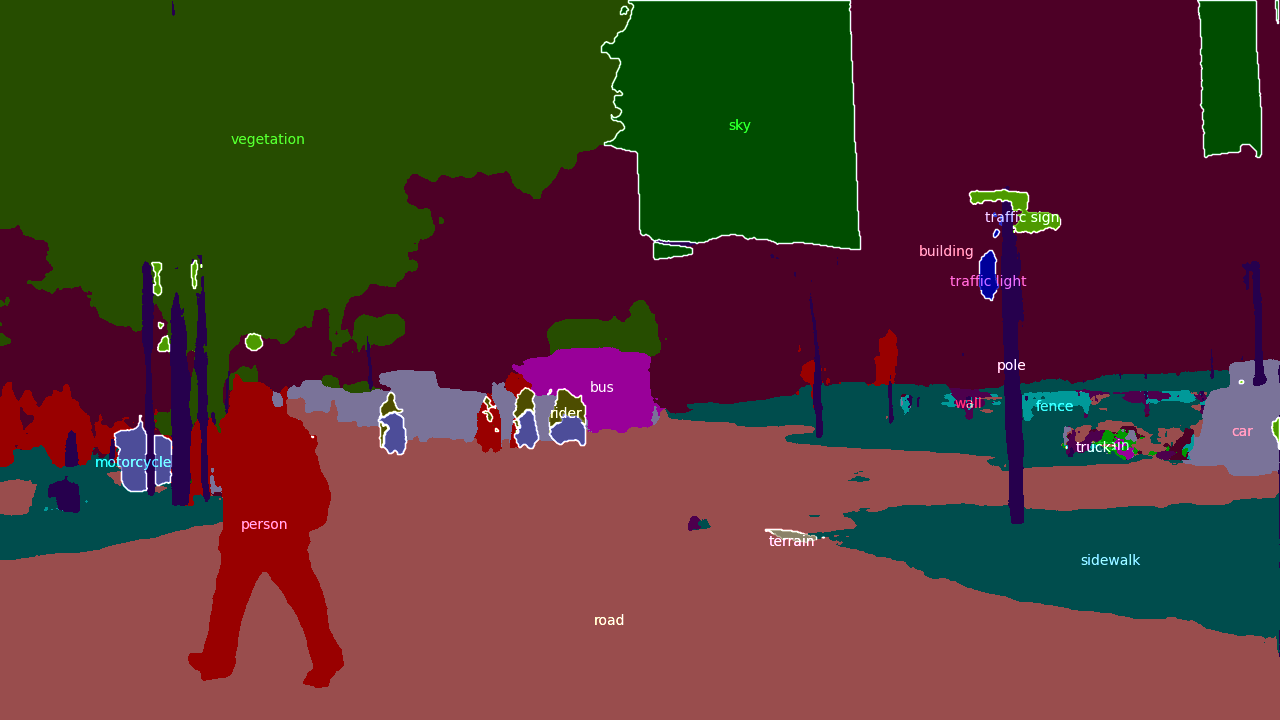

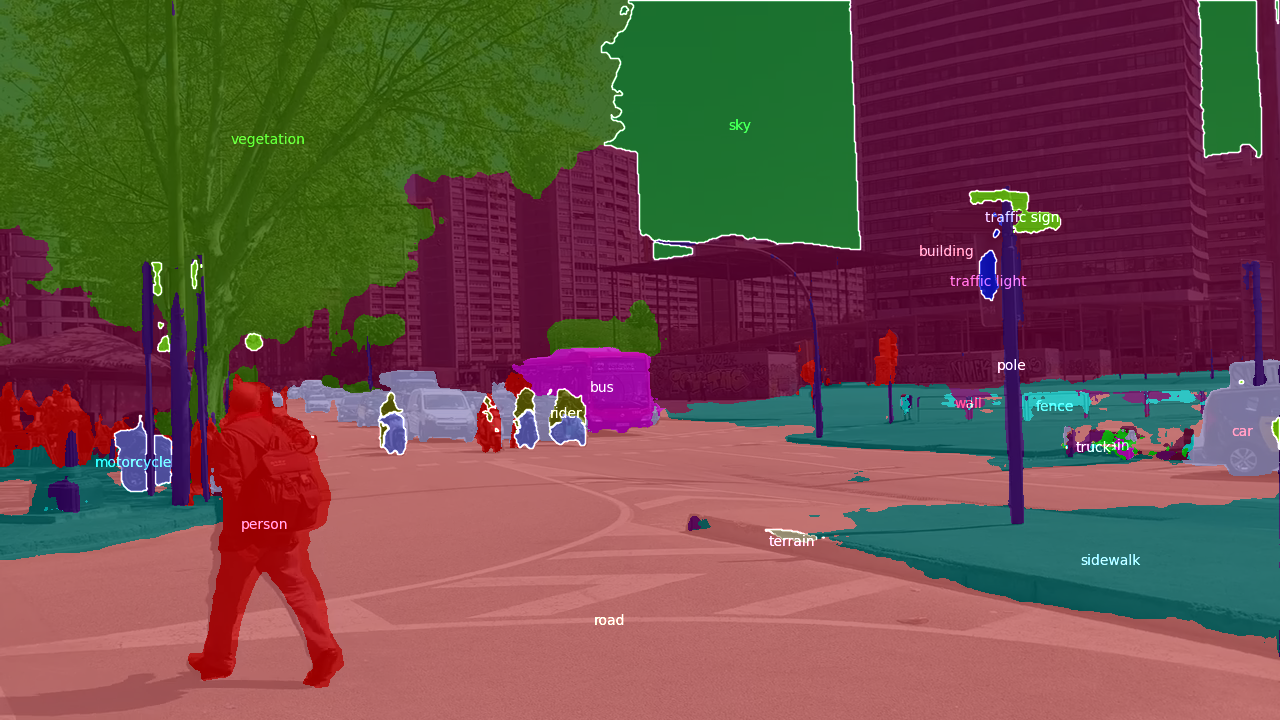

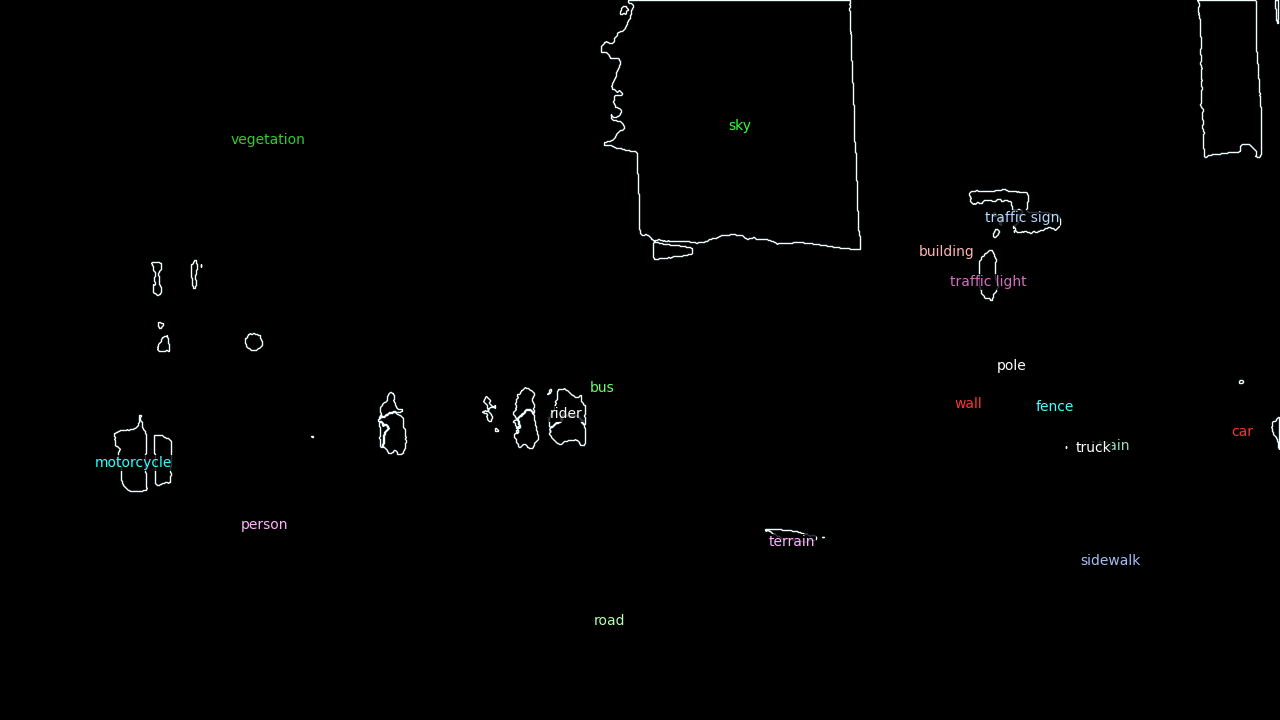

In [15]:
import random

# Provided color list
provided_colors = [
    (255, 0, 0),     # Red
    (0, 255, 0),     # Green
    (0, 0, 255),     # Blue
    (255, 255, 0),   # Yellow
    (255, 0, 255),   # Magenta
    (0, 255, 255),   # Cyan
    (128, 0, 0),     # Maroon
    (0, 128, 0),     # Olive
    (0, 0, 128),     # Navy
    (128, 128, 0),   # Olive Green
    (128, 0, 128),   # Purple
    (0, 128, 128),   # Teal
    (255, 165, 0),   # Orange
    (128, 128, 128), # Gray
    (128, 128, 255), # Periwinkle
    (128, 0, 64),    # Rose
    (0, 128, 64),    # Jade
    (64, 0, 128),    # Indigo
    (255, 128, 128), # Light Salmon
    (128, 255, 128), # Pale Green
    (173, 216, 230), # Light Blue
    (255, 99, 71),   # Tomato
    (0, 255, 128),   # Spring Green
    (255, 192, 203), # Pink
    (0, 128, 192),   # Steel Blue
]

# Randomize the order
random.shuffle(provided_colors)

# Create the class-to-color mapping
class_colors = {i: color for i, color in enumerate(provided_colors)}

# Map class indices to colors
for class_idx, color in class_colors.items():
    mask = (sem_seg == class_idx)
    colored_sem_seg[mask] = color

# Display the result
cv2_imshow(colored_sem_seg)
overlaid_frame = cv2.addWeighted(colored_sem_seg, 0.6, vis_image.get_image(), 1, 0)
cv2_imshow(overlaid_frame)
overlaid_frame2 = cv2.addWeighted(frame, 0.2, overlaid_frame, 1, 0)
cv2_imshow(overlaid_frame2)
cv2_imshow(vis_image.get_image())